In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import tensorflow as tf
import time
import scipy

import collections, numpy

import data_loader as dl
import data_transformer as dt

from sklearn.cluster import KMeans
from keras.utils import to_categorical

# helper for setting up the bidirectional, multilayer lstm
def bidirectional_lstm(input_data, num_layers, rnn_size, keep_prob, lengths=None):
    output = input_data
    for layer in range(num_layers):
        with tf.variable_scope('encoder_{}'.format(layer),reuse=tf.AUTO_REUSE):

            cell_fw = tf.contrib.rnn.LSTMCell(rnn_size, initializer=tf.truncated_normal_initializer(-0.1, 0.1, seed=2))
            cell_fw = tf.contrib.rnn.DropoutWrapper(cell_fw, input_keep_prob = keep_prob)

            cell_bw = tf.contrib.rnn.LSTMCell(rnn_size, initializer=tf.truncated_normal_initializer(-0.1, 0.1, seed=2))
            cell_bw = tf.contrib.rnn.DropoutWrapper(cell_bw, input_keep_prob = keep_prob)

            outputs, states = tf.nn.bidirectional_dynamic_rnn(cell_fw, 
                                                              cell_bw, 
                                                              output,
                                                              dtype=tf.float32,
                                                              sequence_length=lengths)
            output = tf.concat(outputs,2)

    return output

Using TensorFlow backend.


In [10]:
# change this path to match the path of where you have the
# training_50 and validation files
txt_data_path = '/home/mikey/Data/ProteinNet/casp7_txt/'

max_len = 500 # max len of the protein taken into account
n_angles = 3 # 3 if consider all angles or 2 if only phi and psi

The data_lim is important because so far the full 13000 proteins crashes my system with 16Gb of ram

Load training data

In [11]:
file_name = 'training_50'
data_lim = 2000
prim_train, evo_train, dih_train, mask_train = (dl.parse_primary_from_file(txt_data_path + file_name, data_lim), 
                                                dl.parse_evolutionary_from_file(txt_data_path + file_name, data_lim),
                                                dl.load_file('./'+file_name+'_dih.joblib'),
                                                dl.parse_mask_from_file(txt_data_path + file_name, data_lim))
dih_train = dih_train[:data_lim]
len(prim_train), prim_train[0].shape, len(evo_train), evo_train[0].shape, len(dih_train), dih_train[0].shape, len(mask_train), mask_train[0].shape

Loaded data and filtered line endings
Extracted primary data
Encoded primary sequences
Loaded data and filtered line endings
Extracted evolutionary data


100%|██████████| 2000/2000 [00:00<00:00, 68119.76it/s]


Grouped 21's together
Loaded data and filtered line endings
Extracted mask data


(2000, (70, 20), 2000, (70, 21), 2000, (70, 3), 2000, (70,))

Load validation data

In [12]:
file_name = 'validation'
prim_valid, evo_valid, dih_valid, mask_valid = (dl.parse_primary_from_file(txt_data_path + file_name), 
                                                dl.parse_evolutionary_from_file(txt_data_path + file_name),
                                                dl.load_file('./'+ file_name + '_dih.joblib'),
                                                dl.parse_mask_from_file(txt_data_path + file_name))
len(prim_valid), prim_valid[0].shape, len(evo_valid), evo_valid[0].shape, len(dih_valid), dih_valid[0].shape, len(mask_valid), mask_valid[0].shape

Loaded data and filtered line endings
Extracted primary data
Encoded primary sequences
Loaded data and filtered line endings
Extracted evolutionary data


100%|██████████| 224/224 [00:00<00:00, 68900.27it/s]

Grouped 21's together
Loaded data and filtered line endings
Extracted mask data


(224, (269, 20), 224, (269, 21), 224, (269, 3), 224, (269,))

Pad the data and limit protein length. Prepare the data for training

In [13]:
prim_, evo_, dih_, mask_ = dt.limit_length_and_pad(prim_train, evo_train, dih_train, mask_train, max_len)
x_train, y_train = np.concatenate([prim_, evo_], axis=2), dih_[:,:,:n_angles]
prim_v, evo_v, dih_v, mask_v = dt.limit_length_and_pad(prim_valid, evo_valid, dih_valid, mask_valid, max_len)
x_valid, y_valid = np.concatenate([prim_v, evo_v], axis=2), dih_v[:,:,:n_angles]

x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

padded
(1892,) (70, 20)
padded
(1892,) (70, 21)
padded
(1892,) (70, 3)
padded
(1892,) (70, 1)
padded
(213,) (269, 20)
padded
(213,) (269, 21)
padded
(213,) (269, 3)
padded
(213,) (269, 1)


((1892, 500, 41), (1892, 500, 3), (213, 500, 41), (213, 500, 3))

In [14]:
def manual_clusters(n_clusters):
    # these manually selecteed clusters will be chosen from left to right
    # when n_clusters < man_clusters.shape[0]
    man_clusters = np.array([[-1.5, 0, 0], [-1.5, 2.5, 0], [1.5, 0.5, 0], [-2.2, -2.5, 0],
                          [-1.5, 0, np.pi], [-1.5, 0, -np.pi], [-1.5, 2.5, np.pi], [-1.5, 2.5, -np.pi],
                            [0,0,0],[0,0,0]])
    try:
        return {
            i+1: man_clusters[:i+1] for i in range(man_clusters.shape[0])
        }[n_clusters]
    except KeyError as e:
        print("Manual clusters only support max", man_clusters.shape[0])
        print(e)
        raise

def kmeans_clusters(angles, limit_data, filter_, n_clusters):
    """
        angles: [..., ..., 3]
        limit_data: int, how many protein to consider for clustering
        filter_: bool, deciding if clusters too close to each other should be merged
    """
    def dist2(p1, p2):
        return np.sum((p1-p2)**2)

    def fuse(points, min_dist):
        ret = []
        d2 = min_dist * min_dist
        n = len(points)
        taken = [False] * n
        for i in range(n):
            if not taken[i]:
                count = 1
                point = points[i]
                taken[i] = True
                for j in range(i+1, n):
                    if dist2(points[i], points[j]) < d2:
                        point += points[j]
                        count+=1
                        taken[j] = True
                point /= count
                ret.append(point)
        return np.array(ret)
    
    print("Fitting KMeans...")
    km = KMeans(n_clusters=n_clusters, random_state=0, verbose=0, max_iter=1000).fit(angles[:limit_data].reshape(-1,n_angles))
    print("Done")
    if filter_:
        return fuse(km.cluster_centers_, min_dist=np.abs(np.max(angles)) / 10.)
    else:
        return km.cluster_centers_

def get_cluster_centers(select_clusters_n, mode='manual'):
    return {
        'manual': lambda n_clusters: manual_clusters(n_clusters=n_clusters),
        'kmeans': lambda n_clusters: kmeans_clusters(angles=y_train, limit_data=200, filter_=True, n_clusters=n_clusters)
    }[mode](select_clusters_n)

select_clusters_n = 10
# initialize clusters - this might filter ones that are too close
clusters = get_cluster_centers(select_clusters_n = select_clusters_n, mode='kmeans')[:,:n_angles]
n_clusters_after_fuse = clusters.shape[0]

# add missing clusters to much the desired number
clusters = np.pad(clusters, ((0, select_clusters_n - n_clusters_after_fuse), (0,0)), mode='constant')
n_clusters = clusters.shape[0]

"n_clusters_after_fuse:", n_clusters_after_fuse, 'fused', select_clusters_n - n_clusters_after_fuse, 'padded to', clusters.shape

Fitting KMeans...
Done


('n_clusters_after_fuse:', 10, 'fused', 0, 'padded to', (10, 3))

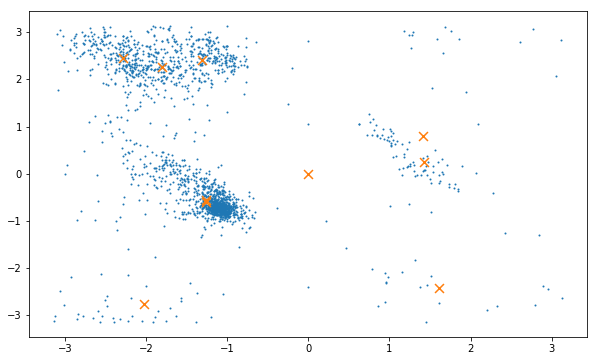

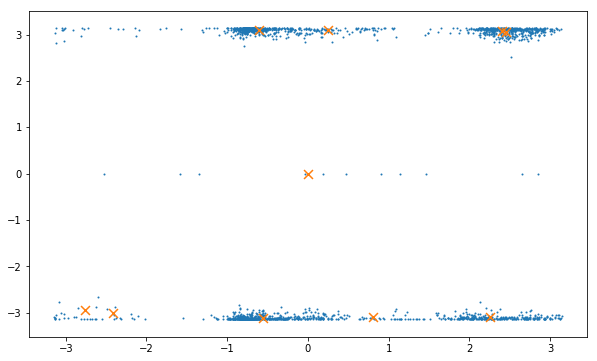

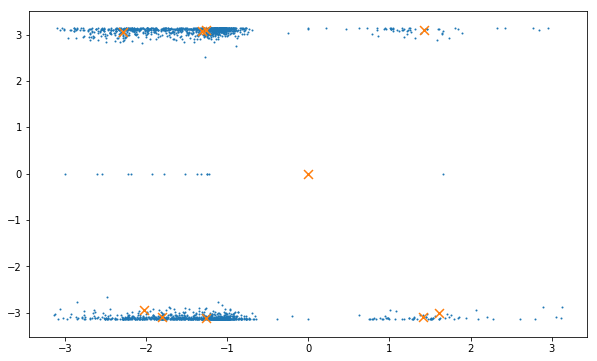

In [15]:
def plot_cluster_centers(data, clusters, x_i, y_i, data_lim=10):
    plt.figure(figsize=(10,6))
    plt.scatter(y_valid[:data_lim][:,:,x_i], y_valid[:data_lim][:,:,y_i], s=1)
    plt.scatter(clusters[:,x_i], clusters[:,y_i], marker='x', s=80)
    
plot_cluster_centers(y_valid, clusters, x_i=0, y_i=1, data_lim=10)
if n_angles == 3:
    plot_cluster_centers(y_valid, clusters, x_i=1, y_i=2, data_lim=10)
    plot_cluster_centers(y_valid, clusters, x_i=0, y_i=2, data_lim=10)

In [16]:
y_train_labels_ = np.argmin(scipy.spatial.distance_matrix(y_train.reshape(-1,n_angles), clusters), 
                            axis=1).reshape(y_train.shape[0], y_train.shape[1])

y_valid_labels_ = np.argmin(scipy.spatial.distance_matrix(y_valid.reshape(-1,n_angles), clusters), 
                            axis=1).reshape(y_valid.shape[0], y_valid.shape[1])

y_train_labels = to_categorical(y_train_labels_, num_classes=n_clusters)
y_valid_labels = to_categorical(y_valid_labels_, num_classes=n_clusters)

y_train_labels.shape, y_valid_labels.shape, np.unique(y_train_labels_), np.unique(y_valid_labels_), n_clusters

((1892, 500, 10),
 (213, 500, 10),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 10)

In [17]:
tf.reset_default_graph()

class ModelHelpers:
    @staticmethod
    @tf.custom_gradient
    def clip_grad_layer(x, eps=1e-10):
        def grad(dy):
            return tf.clip_by_value(dy, eps, eps)
        return tf.identity(x), grad
    
    @staticmethod
    def input_placeholders(max_len, input_columns):
        X = tf.placeholder(tf.float32, [None, max_len, input_columns], name="X")
        input_mask = tf.placeholder(tf.bool, [None, max_len], name="input_mask")
        return X, input_mask

    @staticmethod
    def labels_placeholders(max_len, n_clusters, n_angles):
        y = tf.placeholder(tf.float32, [None, max_len, n_clusters], name='y')
        y_angles = tf.placeholder(tf.float32, [None, max_len, n_angles], name='y_angles')
        return y, y_angles

    @staticmethod
    def clusters(init_clusters, trainable=False, clip_gradient_eps=None):
        clusters_tf = tf.Variable(initial_value=init_clusters, dtype=np.float32, trainable=trainable)
        clusters_tf = tf.clip_by_value(clusters_tf, -np.pi, np.pi)
        if clip_gradient_eps:
            clusters_tf = ModelHelpers.clip_grad_layer(clusters_tf, eps=clip_gradient_eps)
        return clusters_tf

    @staticmethod
    def conv_layer(in_, neurons, filter_size):
        if type(in_) == list:
            in_ = tf.concat(in_, axis=2)
        return tf.layers.conv1d(in_, neurons, filter_size, activation=tf.nn.relu, padding='same')

    @staticmethod
    def mask_all(tensors_list, mask):
        res = []
        for tensor in tensors_list:
            res.append(tf.boolean_mask(tensor, mask))
        return res
    
helpers = ModelHelpers()

X, input_mask = helpers.input_placeholders(max_len = max_len, input_columns = 41)
y, y_angles = helpers.labels_placeholders(max_len, n_clusters, n_angles)

clusters_tf = helpers.clusters(init_clusters=clusters, trainable=False, clip_gradient_eps=None)

# construct the feature extraction part of the network
conv1a = helpers.conv_layer(X, 32, 5)
conv1b = helpers.conv_layer(conv1a, 32, 5)
conv2a = helpers.conv_layer(conv1b, 64, 5)
conv2b = helpers.conv_layer(conv2a, 64, 5)
conv3 = helpers.conv_layer([conv1b, conv2b], 128, 5) # residual connection is automated in the conv_layer helper
conv3 = tf.layers.dropout(conv3, rate=0.5)

## alternative to the cnn. very slow
# lstm = bidirectional_lstm(X, 1, 32, keep_prob=0.05)

# construct the classification part of the network
dense = tf.layers.dense(conv3, 32, activation='relu')
logits = tf.layers.dense(dense, n_clusters)
logits = tf.layers.dropout(logits, rate=0.05)
y_pred = tf.nn.softmax(logits)

# apply mask to all outputs used for losses (beware that the mask flattens them automatically)
y_masked, logits_masked, y_pred_masked, y_angles_masked = helpers.mask_all([y, logits, y_pred, y_angles], input_mask)
shape_after_mask = tf.shape(y_masked)

# computes the weighted sum of clusters (weighted by the predicted prob. dist.)
rad_pred = tf.einsum('ij,bi->bj', clusters_tf, y_pred_masked)

# crossentropy loss on the classification task
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_masked, logits=logits_masked))

# mae computed for each angle separately
mae_vec = tf.reduce_mean(tf.abs(tf.subtract(rad_pred[:,:], y_angles_masked[:,:])), axis=0)
# mae reduced to 1 number
mae = tf.reduce_mean(tf.abs(tf.subtract(rad_pred[:,:], y_angles_masked[:,:])))

# Define the optimizer operation
learning_rate = tf.placeholder(tf.float32)

# we can choose if we want to optimize mae or loss
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

# Variables for prediction and accuracy
prediction = tf.argmax(y_pred_masked, 1)
accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, tf.argmax(y_masked, 1)), tf.float32))

# Initialize the variables (they are assigned default values)
init = tf.global_variables_initializer()

n_parameters = np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()])
print("Number of parameters:", n_parameters)

Number of parameters: 108618


/home/mikey/.local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [ ]:
def pearson_numpy(y_true, y_pred):
    a_phi, a_psi, a_omega = np.split(np.cos(y_true.reshape(-1,)).reshape(-1,3), 
                                     indices_or_sections=3, axis=-1)
    b_phi, b_psi, b_omega = np.split(np.cos(y_pred.reshape(-1,)).reshape(-1,3),
                                     indices_or_sections=3, axis=-1)
    return (scipy.stats.pearsonr(a_phi.reshape(-1,), b_phi.reshape(-1,))[0],
            scipy.stats.pearsonr(a_psi.reshape(-1,), b_psi.reshape(-1,))[0],
            scipy.stats.pearsonr(a_omega.reshape(-1,), b_omega.reshape(-1,))[0])

batch_size = 32
n_epochs = 500

# Start as session
init_learning_rate = 0.01
with tf.Session() as session:

    # Run the initializer
    session.run(init)

    # Training cycle
    for epoch in range(n_epochs):
        print("Epoch:", epoch)
        train_loss = []
        for b in range(0, x_train.shape[0], batch_size):
            _, loss_value, mae_ = session.run([optimizer, loss, mae_vec], feed_dict={X: x_train[b:b+batch_size],
                                                                      y: y_train_labels[b:b+batch_size],
                                                                      y_angles: y_train[b:b+batch_size],
                                                                      learning_rate: init_learning_rate,
                                                                    input_mask: mask_[b:b+batch_size]})
            train_loss.append(mae_)
        
        (validation_accuracy, mae_, pred_, 
         clusters_, y_pred_masked_, rad_pred_) = session.run([accuracy, mae_vec, prediction, 
                                                              clusters_tf, y_pred_masked, rad_pred], 
                                                              feed_dict={X: x_valid, y: y_valid_labels, 
                                                                         y_angles:y_valid,
                                                                        input_mask: mask_v})
        print("val. loss = %f, val_acc = %f" % (loss_value, validation_accuracy))    
        print("Train MAE = %f" % (np.mean(train_loss)))
        print("Val. MAE", mae_, np.mean(mae_))
        print(collections.Counter(pred_))
#         print(np.mean(y_pred_masked_, axis=0)) # prob. dist mean over clusters
#         print(np.max(y_pred_masked_, axis=0)) # prob. dist max over clusters
        print(init_learning_rate)
#         print(clusters_)
        
        # Shrinks the learning rate every n epochs
        train_loss = []
        if (epoch + 1) % 10 == 0:
            print("Adjusting learning rate")
            init_learning_rate = init_learning_rate / 1.1
    
    print("Optimization done")

    # Calculate training accuracy
    train_accuracy_value, pred_train, shape_after_mask_ = session.run([accuracy, prediction, shape_after_mask], 
                                                                      feed_dict={X: x_train, y: y_train_labels,
                                                                                y_angles: y_train,
                                                                                input_mask: mask_})
    print("Train accuracy:", train_accuracy_value)
    print("Shape after mask:", shape_after_mask_)
    
    # Calculate test accuracy
    test_accuracy_value, pred_test, shape_after_mask_ = session.run([accuracy, prediction, shape_after_mask], 
                                                                    feed_dict={X: x_valid, y: y_valid_labels,
                                                                              y_angles: y_valid,
                                                                              input_mask: mask_v})
    print("Test accuracy:", test_accuracy_value)
    print("Shape after mask:", shape_after_mask_)

Epoch: 0
val. loss = 2.069426, val_acc = 0.399081
Train MAE = 1.185669
Val. MAE [0.85706544 1.429034  ] 1.1430497
Counter({2: 37634})
0.01
Epoch: 1
val. loss = 1.887506, val_acc = 0.399081
Train MAE = 1.079500
Val. MAE [0.6514447 1.4176172] 1.0345309
Counter({2: 37634})
0.01
Epoch: 2
val. loss = 1.820335, val_acc = 0.399081
Train MAE = 1.022549
Val. MAE [0.61365324 1.4212339 ] 1.0174435
Counter({2: 37634})
0.01
Epoch: 3
val. loss = 1.783652, val_acc = 0.399081
Train MAE = 1.014827
Val. MAE [0.6041448 1.4269726] 1.0155587
Counter({2: 37634})
0.01
Epoch: 4
val. loss = 1.768517, val_acc = 0.399081
Train MAE = 1.014469
Val. MAE [0.60267454 1.4303524 ] 1.0165135
Counter({2: 37634})
0.01
Epoch: 5
val. loss = 1.761316, val_acc = 0.399081
Train MAE = 1.015041
Val. MAE [0.60303676 1.4312428 ] 1.0171398
Counter({2: 37634})
0.01
Epoch: 6
val. loss = 1.754615, val_acc = 0.399081
Train MAE = 1.014884
Val. MAE [0.60342646 1.4299843 ] 1.0167054
Counter({2: 37634})
0.01
Epoch: 7
val. loss = 1.746906, 

val. loss = 1.381225, val_acc = 0.462295
Train MAE = 0.833907
Val. MAE [0.55861104 1.1273702 ] 0.84299064
Counter({2: 21305, 9: 8306, 3: 5449, 5: 1283, 4: 1067, 1: 224})
0.006830134553650705
Epoch: 49
val. loss = 1.376550, val_acc = 0.463836
Train MAE = 0.830192
Val. MAE [0.55723274 1.1217344 ] 0.83948356
Counter({2: 21094, 9: 8150, 3: 5602, 5: 1287, 4: 1195, 1: 306})
0.006830134553650705
Adjusting learning rate
Epoch: 50
val. loss = 1.371013, val_acc = 0.466466
Train MAE = 0.826510
Val. MAE [0.55577636 1.1156979 ] 0.8357371
Counter({2: 21047, 9: 7930, 3: 5639, 4: 1314, 5: 1305, 1: 399})
0.006209213230591549
Epoch: 51
val. loss = 1.367385, val_acc = 0.468619
Train MAE = 0.823362
Val. MAE [0.5545583 1.1109635] 0.8327609
Counter({2: 20825, 9: 7850, 3: 5732, 4: 1407, 5: 1311, 1: 509})
0.006209213230591549
Epoch: 52
val. loss = 1.364025, val_acc = 0.470612
Train MAE = 0.820325
Val. MAE [0.55339944 1.1066372 ] 0.83001834
Counter({2: 20596, 9: 7760, 3: 5814, 4: 1492, 5: 1328, 1: 644})
0.0062

val. loss = 1.303081, val_acc = 0.498087
Train MAE = 0.766932
Val. MAE [0.52484846 1.0275939 ] 0.77622116
Counter({2: 17972, 9: 7851, 3: 5040, 1: 3250, 4: 2158, 5: 1363})
0.004665073802097332
Adjusting learning rate
Epoch: 90
val. loss = 1.299183, val_acc = 0.499894
Train MAE = 0.765932
Val. MAE [0.5239397 1.0244449] 0.77419233
Counter({2: 18276, 9: 7648, 3: 4919, 1: 3237, 4: 2162, 5: 1392})
0.004240976183724847
Epoch: 91
val. loss = 1.298652, val_acc = 0.500239
Train MAE = 0.765293
Val. MAE [0.52357095 1.0234325 ] 0.77350175
Counter({2: 18264, 9: 7649, 3: 4933, 1: 3228, 4: 2167, 5: 1393})
0.004240976183724847
Epoch: 92
val. loss = 1.298117, val_acc = 0.500399
Train MAE = 0.764675
Val. MAE [0.5232481 1.0225922] 0.77292013
Counter({2: 18229, 9: 7664, 3: 4931, 1: 3241, 4: 2169, 5: 1400})
0.004240976183724847
Epoch: 93
val. loss = 1.297521, val_acc = 0.500638
Train MAE = 0.764073
Val. MAE [0.52295965 1.0218934 ] 0.7724265
Counter({2: 18180, 9: 7682, 3: 4953, 1: 3239, 4: 2170, 5: 1410})
0.

val. loss = 1.271402, val_acc = 0.509858
Train MAE = 0.746534
Val. MAE [0.51305825 0.99232554] 0.75269186
Counter({2: 18425, 9: 7137, 3: 5077, 1: 3091, 4: 2206, 5: 1698})
0.0028966437973668773
Epoch: 131
val. loss = 1.271082, val_acc = 0.510071
Train MAE = 0.746199
Val. MAE [0.5128967 0.9918397] 0.7523682
Counter({2: 18414, 9: 7134, 3: 5093, 1: 3089, 4: 2204, 5: 1700})
0.0028966437973668773
Epoch: 132
val. loss = 1.270735, val_acc = 0.510097
Train MAE = 0.745850
Val. MAE [0.5127332 0.9913219] 0.7520276
Counter({2: 18402, 9: 7134, 3: 5097, 1: 3088, 4: 2206, 5: 1707})
0.0028966437973668773
Epoch: 133
val. loss = 1.270379, val_acc = 0.510124
Train MAE = 0.745506
Val. MAE [0.5125771 0.9908344] 0.75170577
Counter({2: 18387, 9: 7130, 3: 5109, 1: 3091, 4: 2208, 5: 1709})
0.0028966437973668773
Epoch: 134
val. loss = 1.270035, val_acc = 0.510363
Train MAE = 0.745178
Val. MAE [0.5124035  0.99027944] 0.75134146
Counter({2: 18386, 9: 7126, 3: 5106, 1: 3097, 4: 2208, 5: 1711})
0.0028966437973668773

val. loss = 1.252896, val_acc = 0.516793
Train MAE = 0.733654
Val. MAE [0.50684536 0.9719739 ] 0.7394096
Counter({2: 18505, 9: 6776, 3: 5162, 1: 3078, 4: 2205, 5: 1908})
0.00197844668900135
Epoch: 172
val. loss = 1.252603, val_acc = 0.517086
Train MAE = 0.733400
Val. MAE [0.5067411 0.9716237] 0.7391824
Counter({2: 18487, 9: 6785, 3: 5167, 1: 3077, 4: 2204, 5: 1914})
0.00197844668900135
Epoch: 173
val. loss = 1.252293, val_acc = 0.517325
Train MAE = 0.733153
Val. MAE [0.50662684 0.9712247 ] 0.7389258
Counter({2: 18481, 9: 6780, 3: 5171, 1: 3078, 4: 2205, 5: 1919})
0.00197844668900135
Epoch: 174
val. loss = 1.251993, val_acc = 0.517750
Train MAE = 0.732916
Val. MAE [0.506515  0.9708482] 0.7386816
Counter({2: 18479, 9: 6785, 3: 5171, 1: 3074, 4: 2204, 5: 1921})
0.00197844668900135
Epoch: 175
val. loss = 1.251659, val_acc = 0.517962
Train MAE = 0.732664
Val. MAE [0.5064048 0.970462 ] 0.7384334
Counter({2: 18466, 9: 6790, 3: 5176, 1: 3070, 4: 2205, 5: 1927})
0.00197844668900135
Epoch: 176
v

val. loss = 1.239247, val_acc = 0.521842
Train MAE = 0.724360
Val. MAE [0.50265986 0.9570929 ] 0.7298764
Counter({2: 18597, 9: 6566, 3: 5194, 1: 3028, 4: 2209, 5: 2040})
0.001351305709310395
Epoch: 213
val. loss = 1.238986, val_acc = 0.521895
Train MAE = 0.724183
Val. MAE [0.50257903 0.9567976 ] 0.7296883
Counter({2: 18605, 9: 6562, 3: 5194, 1: 3025, 4: 2205, 5: 2043})
0.001351305709310395
Epoch: 214
val. loss = 1.238737, val_acc = 0.522081
Train MAE = 0.723999
Val. MAE [0.5025    0.9565044] 0.7295022
Counter({2: 18603, 9: 6562, 3: 5197, 1: 3022, 4: 2206, 5: 2044})
0.001351305709310395
Epoch: 215
val. loss = 1.238495, val_acc = 0.522187
Train MAE = 0.723822
Val. MAE [0.50241643 0.9561953 ] 0.72930586
Counter({2: 18602, 9: 6559, 3: 5199, 1: 3023, 4: 2207, 5: 2044})
0.001351305709310395
Epoch: 216
val. loss = 1.238240, val_acc = 0.522214
Train MAE = 0.723642
Val. MAE [0.50233376 0.9558855 ] 0.72910964
Counter({2: 18602, 9: 6559, 3: 5199, 1: 3023, 4: 2208, 5: 2043})
0.001351305709310395
E

In [22]:
np.min(rad_pred_)

-0.22896507

Organize model modes:
- predict angles through regression (tanh, *pi)
- predict clusters and optimize for crossentropy
- predict clusters and optimize for MAE
- predict clusters as vectors and optimize for MAE

In [46]:
np.mean(np.abs(clusters_[pred_] - y_valid[mask_v])

array([[0.853431  , 0.29503512, 3.1235397 ],
       [0.57627773, 0.61460125, 3.1102312 ],
       [0.13828385, 0.36523938, 2.9928179 ],
       ...,
       [0.1008271 , 3.0192895 , 3.137029  ],
       [0.251745  , 3.2153685 , 3.141288  ],
       [0.19128823, 2.8222716 , 0.48199463]], dtype=float32)

resnet CNN filter_length = 15 (with 5 it didn't change much either)

*Rad angles, 10 not trainable clusters: 0.59

*Rad angles, 10 trainable clusters, no clipping: MAE [0.43384644 0.721744  ] 0.5777952

*Rad angles, 50 trainable clusters, no clipping: 
Train MAE = 0.545068
Val. MAE [0.43777448 0.7208223 ] 0.5792984